In [1]:
# Google Colab preparation

%%capture

!pip install scikit-optimize
!pip install imblearn

!git clone https://github.com/ReadingHui/tabular-playground-s4e10-loan-approval

import sys
sys.path.insert(0,'/content/tabular-playground-s4e10-loan-approval')

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical
from imblearn.over_sampling import RandomOverSampler

import matplotlib.pyplot as plt
import preprocess

import torch
from torch import nn
from torch import optim
import torch.utils.data as data_utils
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


# Global Variables

In [3]:
# In Google Colab
train_path = '/content/tabular-playground-s4e10-loan-approval/train.csv'
test_path = '/content/tabular-playground-s4e10-loan-approval/test.csv'

# # In Local machine
# train_path = 'train.csv'
# test_path = 'test.csv'

random_state = 1048576
target = 'loan_status'
cat_features = [
    'person_home_ownership',
    'loan_intent',
    'loan_grade',
    'cb_person_default_on_file'
]

num_features = [
    'person_age',
    'person_income',
    'person_emp_length',
    'loan_amnt',
    'loan_int_rate',
    'loan_percent_income',
    'cb_person_cred_hist_length'
]

# Data Loading and Preprocessing

In [4]:
# Data Loading
X_train, X_test, y_train, y_test = preprocess.DataImport.get_train_test(
    train_path, index_col=0, target=target,
    random_state=random_state, verbose=1
    )

# Train - Validation Split
X_train, X_val, y_train, y_val = train_test_split(
            X_train, y_train, test_size=0.1, random_state=random_state)

print(f'Shape of X_train is: {X_train.shape}; ',
      f'shape of y_train is: {y_train.shape}')
print(f'Shape of X_val is: {X_val.shape}; ',
      f'shape of y_test is: {y_val.shape}')

# Remove outliers
X_train, y_train = preprocess.Outliers.remove_outliers(
    X_train, y_train, verbose=1
    )

# One-Hot Encode
encoder = preprocess.CategoryEncoder(cat_features=cat_features,
                                     method='one_hot')
X_train = encoder.fit_transform(X_train)
X_val = encoder.transform(X_val)
X_test = encoder.transform(X_test)

# Standard Scaling
scaler = StandardScaler()
features = X_train.columns
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=features)
X_val = pd.DataFrame(scaler.transform(X_val), columns=features)
X_test = pd.DataFrame(scaler.transform(X_test), columns=features)

# # Oversampling (Worse outcome, leaves here for future reference)
# print(f'Target distribution before oversampling: ',
#       f'(0: {round(y_train.sum() / y_train.size * 100, 2)}%, ',
#       f'1: {round((1 - y_train.sum() / y_train.size) * 100, 2)}%)')
# oversampler = RandomOverSampler(random_state=random_state)
# X_train, y_train = oversampler.fit_resample(X_train, y_train)
# print(f'X_train shape after oversampling: {X_train.shape}; ',
#       f'y_train shape after oversampling: {X_train.shape}')
# print(f'Target distribution after oversampling: ',
#       f'(0: {round(y_train.sum() / y_train.size * 100, 2)}%, ',
#       f'1: {round((1 - y_train.sum() / y_train.size) * 100, 2)}%)')

# Create data loaders
def create_data_loader(X: pd.DataFrame | np.ndarray, y: pd.Series | np.ndarray,
                       batch_size: int = 32, shuffle: bool = True):
    X = torch.tensor(X.values, dtype=torch.float32)
    y = torch.tensor(y.values, dtype=torch.float32)
    data_tensor = data_utils.TensorDataset(X, y)
    data_loader = data_utils.DataLoader(dataset=data_tensor,
                                         batch_size=batch_size,
                                         shuffle=shuffle)
    return data_loader

train_loader = create_data_loader(X_train, y_train)
val_loader = create_data_loader(X_val, y_val)
test_loader = create_data_loader(X_test, y_test)

Shape of X_train is: (52780, 11); shape of y_train is: (52780,)
Shape of X_test is: (5865, 11); shape of y_test is: (5865,)
Shape of X_train is: (47502, 11);  shape of y_train is: (47502,)
Shape of X_val is: (5278, 11);  shape of y_test is: (5278,)
New shape of X_train is: (47371, 11); New shape of y_train is: (47371,)


# Model building

In [5]:
# Define the neural network model
class BinaryClassificationNN(nn.Module):
    def __init__(self):
        super(BinaryClassificationNN, self).__init__()

        # Define the layers
        self.fc1 = nn.Linear(in_features=26, out_features=32)
        self.fc2 = nn.Linear(in_features=32, out_features=32)
        self.fc3 = nn.Linear(in_features=32, out_features=1)

        # Activation function
        self.relu = nn.ReLU()

        # Sigmoid for probability output
        self.sigmoid = nn.Sigmoid()

        # Initialize weights
        self.init_weights()  # Custom weight initialization

    def init_weights(self):
        # Initialize weights with Xavier (Glorot) initialization
        nn.init.xavier_uniform_(self.fc1.weight)
        nn.init.xavier_uniform_(self.fc2.weight)
        nn.init.xavier_uniform_(self.fc3.weight)

        # Optionally, initialize biases to zero
        nn.init.zeros_(self.fc1.bias)
        nn.init.zeros_(self.fc2.bias)
        nn.init.zeros_(self.fc3.bias)


    def forward(self, X: pd.DataFrame | np.ndarray) -> pd.DataFrame | np.ndarray:
        X = self.relu(self.fc1(X))
        X = self.relu(self.fc2(X))
        X = self.sigmoid(self.fc3(X)) # Sigmoid for binary classification
        return X



# Model Training

In [6]:
def save_checkpoint(model: nn.Module, optimizer: optim.Optimizer,
                    epoch: int, loss: float, score: float,
                    filename: str = 'checkpoint.pth', verbose: bool = False):
    torch.save({
        'epoch': epoch + 1,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss,
        'score': score
    }, filename)
    if verbose:
        print(f'Checkpoint saved at epoch {epoch + 1}')

def load_checkpoint(filename: str = 'checkpoint.pth'):
    model = BinaryClassificationNN()
    optimizer = optim.Adam(model.parameters())
    checkpoint = torch.load(filename, weights_only=False)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    loss = checkpoint['loss']
    return model, optimizer, epoch, loss

In [7]:
class EarlyStopping:
    def __init__(self, patience: int = 5, method: str = 'loss'):
        self.patience = patience
        self.method = method
        self.counter = 0
        self.best_value = np.inf
        self.early_stop = False

    def __call__(self, val_value):
        if self.method == 'loss':
            val_value = val_value
        elif self.method == 'score':
            val_value = -val_value
        if val_value < self.best_value:
            self.best_value = val_value
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

In [8]:
def model_score(model: nn.Module,
               data_loader: data_utils.DataLoader,
                device: str = device):
    dataset = data_loader.dataset

    model.eval()
    with torch.no_grad():
        # Evaluate inputs
        outputs = model(dataset.tensors[0].to(device)).cpu()
        labels = dataset.tensors[1]

        # Calculate score
        score = roc_auc_score(labels, outputs)
    return score

def train_model(model: nn.Module,
                train_loader: data_utils.DataLoader,
                eval_loader: data_utils.DataLoader = None,
                num_epochs: int = 10, learning_rate: float = 0.01,
                weight_decay: float = 1e-3,
                criterion: torch.nn.modules.loss = nn.BCELoss(),
                device: str = 'cpu',
                early_stopping_method: str = 'loss',
                early_stopping_patience: int = 5,
                save_path: str = None,
                verbose: int = 1, random_state=random_state):
    # Initialize optimizer, early_stopping and history parameters
    optimizer = optim.Adam(model.parameters(),
                           lr=learning_rate,
                           weight_decay=weight_decay)
    early_stopping = EarlyStopping(patience=early_stopping_patience,
                                   method=early_stopping_method)
    best_val = np.inf

    losses = {"train": [], "val": []}
    scores = {"train": [], "val": []}

    for epoch in range(num_epochs):  # Training loop
            # Training phrase
            total_train_loss = 0

            model.train()  # Set the model to training mode
            torch.manual_seed(random_state)
            for batch_idx, (inputs, labels) in enumerate(train_loader):
                # Cast to device
                inputs, labels = inputs.to(device), labels.to(device)

                # Forward pass
                outputs = model(inputs)
                outputs = torch.squeeze(outputs)

                # Compute the loss
                loss = criterion(outputs, labels)

                # Backpropagation and optimization
                optimizer.zero_grad()  # Clear previous gradients
                loss.backward() # Backpropagate
                optimizer.step() # Update weights

                # Rolling sum of training loss
                total_train_loss += loss.item()

                # If large verbose print batch loss
                if verbose > 1:
                    print_freq = num_epochs // 10
                    if batch_idx % print_freq == 0:
                        print(f"Epoch [{epoch+1}/{num_epochs}], \
                        Batch [{batch_idx}], \
                        Loss: {loss.item():.4f}") # Printing loss

            # Store the loss value for this epoch
            average_train_loss = total_train_loss / len(train_loader)
            losses['train'].append(average_train_loss)

            # Evaluate training score
            train_score = model_score(model, train_loader)
            scores['train'].append(train_score)
            if verbose > 0 and not eval_loader:
                print(f"Epoch [{epoch+1}/{num_epochs}], ",
                    f"Average Train Loss: {average_train_loss:.4f}, ",
                    f"Training Score: {train_score:.4f}.") # Printing loss

            if eval_loader:
                total_val_loss = 0 # Initiate total_val loss

                model.eval()  # Set the model to evaluation mode
                # Evaluate the model on the validation set
                torch.manual_seed(random_state)
                for inputs, labels in eval_loader: # For each batch
                    # Cast to device
                    inputs, labels = inputs.to(device), labels.to(device)

                    # Forward pass
                    outputs = model(inputs)
                    outputs = torch.squeeze(outputs)

                    # Compute the loss
                    loss = criterion(outputs, labels)
                    total_val_loss += loss.item() # Rolling sum of training loss

                # Store the loss value for this epoch
                average_val_loss = total_val_loss / len(eval_loader)
                losses['val'].append(average_val_loss)

                # Evaluate validation score
                val_score = model_score(model, eval_loader)
                scores['val'].append(val_score)

                if verbose > 0:
                    print(f"Epoch [{epoch+1}/{num_epochs}], ",
                    f"Average Train Loss: {average_train_loss:.4f}, ",
                    f"Training Score: {train_score:.4f}, ",
                    f"Average Val Loss: {average_val_loss:.4f}, ",
                    f"Validation Score: {val_score:.4f}.") # Printing loss

            # Update best model
            if eval_loader:
                compare_set = 'val'
            else:
                compare_set = 'train'
            if early_stopping_method == 'loss':
                compare_val = losses[compare_set][-1]
            elif early_stopping_method == 'score':
                compare_val = - scores[compare_set][-1]
            if compare_val < best_val:
                best_val = compare_val
                save_checkpoint(model, optimizer, epoch,
                                losses[compare_set][-1],
                                scores[compare_set][-1],
                                save_path, verbose)


            # Early Stopping
            if early_stopping_method == 'loss':
                early_stopping(average_val_loss)
            elif early_stopping_method == 'score':
                early_stopping(val_score)
            if early_stopping.early_stop:
                print(f"Early stopping triggered, ",
                      f"validation {early_stopping_method} not improved ",
                      f"after {early_stopping_patience} epochs")
                break
    # Pack history
    history = {}
    history['loss'] = losses
    history['scores'] = scores

    return history

In [9]:
num_epochs = 1000

torch.manual_seed(random_state)
model = BinaryClassificationNN()
model = model.to(device)
history = train_model(model,
                      train_loader, val_loader,
                      num_epochs,
                      learning_rate=0.001,
                      device=device,
                      early_stopping_patience=10,
                      early_stopping_method='loss',
                      save_path='PyTorch_best_model.pt',
                      random_state=random_state)

Epoch [1/1000],  Average Train Loss: 0.2353,  Training Score: 0.9232,  Average Val Loss: 0.2046,  Validation Score: 0.9229.
Checkpoint saved at epoch 1
Epoch [2/1000],  Average Train Loss: 0.1957,  Training Score: 0.9268,  Average Val Loss: 0.1970,  Validation Score: 0.9258.
Checkpoint saved at epoch 2
Epoch [3/1000],  Average Train Loss: 0.1906,  Training Score: 0.9285,  Average Val Loss: 0.1942,  Validation Score: 0.9270.
Checkpoint saved at epoch 3
Epoch [4/1000],  Average Train Loss: 0.1879,  Training Score: 0.9295,  Average Val Loss: 0.1917,  Validation Score: 0.9283.
Checkpoint saved at epoch 4
Epoch [5/1000],  Average Train Loss: 0.1858,  Training Score: 0.9301,  Average Val Loss: 0.1905,  Validation Score: 0.9287.
Checkpoint saved at epoch 5
Epoch [6/1000],  Average Train Loss: 0.1845,  Training Score: 0.9307,  Average Val Loss: 0.1893,  Validation Score: 0.9294.
Checkpoint saved at epoch 6
Epoch [7/1000],  Average Train Loss: 0.1837,  Training Score: 0.9311,  Average Val Loss:

# Loss analysis

In [10]:
def plot_loss(history, loss: bool = True, score: bool = False):
    num_epochs = len(history['loss']['train'])
    if not loss and not score:
        raise ValueError('Cannot have both loss and score set as False')

    if loss:
        plt.plot(range(1, num_epochs+1), history['loss']['train'], marker='o')
        plt.plot(range(1, num_epochs+1), history['loss']['val'], marker='o')
    if score:
        plt.plot(range(1, num_epochs+1), history['scores']['train'], marker='x')
        plt.plot(range(1, num_epochs+1), history['scores']['val'], marker='x')

    if loss and score:
        plt.title('Training Loss and Scores Over Epochs')
    elif score:
        plt.title('Scores Over Epochs')
    elif loss:
        plt.title('Training Loss Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.legend(['Train', 'Validation'])
    plt.show()

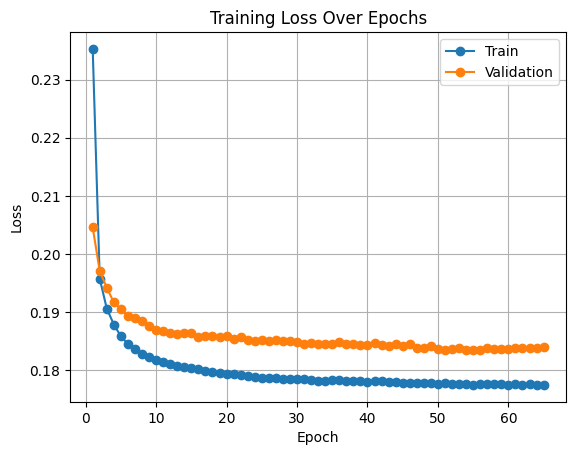

In [11]:
plot_loss(history)

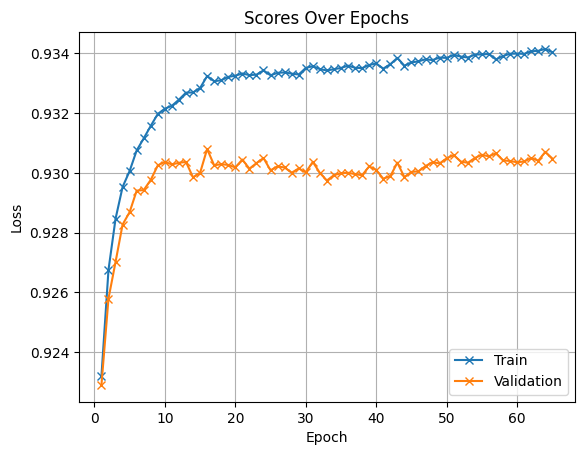

In [12]:
plot_loss(history, loss=False, score=True)

In [16]:
best_model, optimizer, epoch, loss = load_checkpoint('PyTorch_best_model.pt')

In [17]:
best_model = best_model.to(device)
best_model.eval()
test_score = round(model_score(model, test_loader), 4)
print(f'Test Score: {test_score}')

Test Score: 0.9307


In [15]:
# # Auto terminate session

# from google.colab import runtime
# runtime.unassign()